/home/work/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/work/anaconda3/envs/ldm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 25/25 [00:01<00:00, 16.15it/s]


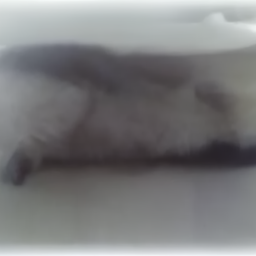

In [1]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

**## UNet2DModel, DDPMScheduler**

위의 예시에서, 파이프라인은 UNet2DModel 모델과 DDPMScheduler를 포함하고 있습니다. 이 파이프라인은 원하는 출력 크기의 random noise를 취하고 이를 여러 번 모델을 통해 전달하여 이미지를 noise를 제거합니다. 각 timestep에서, 모델은 noise residual을 예측하고 Scheduler는 이를 사용하여 더 적은 noise의 이미지를 예측합니다. 이 과정은 지정된 inference steps의 끝에 도달할 때까지 반복됩니다.

In [2]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [3]:
scheduler.set_timesteps(100)

Scheduler의 timesteps를 설정하면, 이 예에서는 100개의 요소가 균일하게 배치된 tensor가 생성됩니다. 각 요소는 모델이 이미지에서 noise를 제거하는 timesteps에 해당합니다. 나중에 noise 제거 loop를 생성할 때, 이 tensor를 반복하면서 이미지에서 noise를 제거할 것입니다.

scheduler.timesteps

In [4]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

다음은 timesteps를 반복하는 루프를 작성하는 방법의 예입니다. 각 timestep에서 모델은 UNet2DModel.forward()를 실행하고 noisy residual을 반환합니다. Scheduler의 step() 메소드는 noisy residual, timestep, 그리고 입력을 받아 이전 timestep에서의 이미지를 예측합니다. 이 출력은 denoising 루프에서 모델의 다음 입력이 되며, timesteps 배열의 끝에 도달할 때까지 반복됩니다.

- model(x, timestep)은 주어진 timestep과 현재 입력 x를 사용하여 UNet2DModel이 noisy residual을 계산하는 작업을 나타냅니다.

- scheduler.step(noisy_residual, timestep, x)은 noisy residual과 특정 timestep에서의 현재 입력 이미지 x를 사용하여 이전 timestep에서의 이미지 상태를 예측합니다. 그 결과는 다음 모델 입력으로 사용됩니다.

- 이 루프는 timesteps 텐서의 모든 요소를 처리할 때까지 반복되며, 점차 이미지를 denoising합니다.

In [5]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

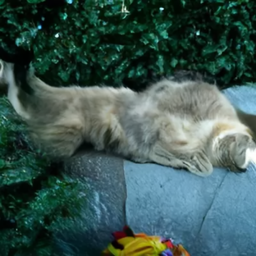

In [6]:
# Convert the denoised output into an image

from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image


# Deconstruct the Stable Diffusion pipeline

Stable Diffusion은 텍스트에서 이미지로 변환하는 latent Diffusion model입니다. 이 모델이 latent diffusion model로 불리는 이유는 실제 pixel space 대신 이미지의 저차원 표현을 사용하기 때문이며, 이는 메모리 효율성을 높입니다. encoder는 이미지를 더 작은 표현으로 압축하고, decoder는 압축된 표현을 다시 이미지로 변환합니다. Text에서 이미지로 변환하는 모델의 경우, 텍스트 임베딩을 생성하기 위해 Tokenizer와 encoder가 필요합니다. 

In [7]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [8]:
# 기본 PNDMScheduler 대신에 UniPCMultistepScheduler로 교체할 수 있습니다.

from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

/home/work/anaconda3/envs/ldm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

텍스트를 토큰화하여 임베딩을 생성합니다. 이 텍스트는 UNet 모델을 조건화하는 데 사용되며, diffusion process을 입력 프롬프트와 유사한 것으로 유도합니다.

guidance_scale 매개변수는 이미지를 생성할 때 프롬프트에 얼마나 많은 가중치를 줄지 결정합니다.

In [10]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [11]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

Padding token에 대한 임베딩인 unconditional 텍스트 임베딩을 생성해야 합니다. 이들은 conditional 텍스트 임베딩과 동일한 형태(배치 크기와 시퀀스 길이)를 가져야 합니다:

In [12]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [13]:
# conditional and unconditional embeddings into a batch to avoid doing two forward process

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Create random noise


Diffusion process의 시작점으로서 초기 random noise을 생성합니다. 이것은 이미지의 latent representation이며, 점차적으로 noise가 제거됩니다. 이 시점에서 latent 이미지는 최종 이미지 크기보다 작지만, 모델이 나중에 이를 최종 512x512 이미지 차원으로 변환하기 때문에 상관없습니다.

높이와 너비는 vae 모델에 3개의 다운샘플링 레이어가 있기 때문에 8로 나눕니다.

2 ** (len(vae.config.block_out_channels) - 1) == 8

In [18]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator = torch.Generator(device='cuda'),
    device=torch_device,
)

## Denoise the image

input을 초기 noise 분포인 sigma, noise scale 값으로 스케일링하여 시작합니다. UniPCMultistepScheduler와 같은 스케줄러에 사용됩니다.

In [19]:
latents = latents * scheduler.init_noise_sigma

마지막 단계는 순수한 noise를 프롬프트에 설명된 이미지로 점진적으로 변환하는 noise 제거 루프를 생성합니다. noise 제거 루프는 세 가지 작업을 수행해야 합니다.

1. noise 제거 중에 사용할 Scheduler의 timesteps를 설정합니다.

2. timesteps를 반복합니다.

3. 각 timestep에서, UNet 모델을 호출하여 noise residual을 예측하고 이를 Scheduler에 전달하여 이전의 noisy sample을 계산합니다.


In [20]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 25/25 [00:01<00:00, 14.70it/s]


## Decode the image

마지막은 vae를 사용하여 latent representation을 이미지로 디코딩하고 샘플과 함께 디코딩된 출력을 얻습니다.

In [21]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

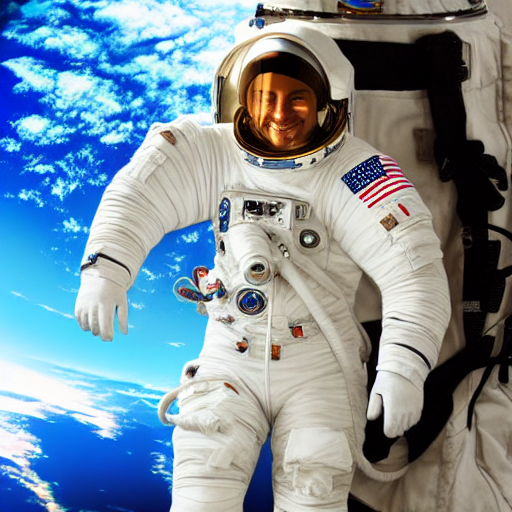

In [22]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image